# transaction features

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

import featuretools as ft

import gc
import os
import sys
os.listdir("./data/")

['all (1).zip',
 'Data_Dictionary.xlsx',
 'features_downcast',
 'historical_transactions.csv',
 'merchants.csv',
 'new_merchant_transactions.csv',
 'sample_submission.csv',
 'test.csv',
 'train.csv']

In [57]:
import addict

In [2]:
from downcast import save_dataframe32, load_dataframe32
from filepath_collection import features_downcast

In [3]:
history_transactions = pd.read_csv("./data/historical_transactions.csv")
new_transactions = pd.read_csv("./data/new_merchant_transactions.csv")

all_transactions = pd.concat([history_transactions, new_transactions])
print(all_transactions.shape)

del history_transactions, new_transactions
gc.collect()

(31075392, 14)


0

In [4]:
all_transactions.head().T

,0,1,2,3,4
authorized_flag,Y,Y,Y,Y,Y
card_id,C_ID_4e6213e9bc,C_ID_4e6213e9bc,C_ID_4e6213e9bc,C_ID_4e6213e9bc,C_ID_4e6213e9bc
city_id,88,88,88,88,88
category_1,N,N,N,N,N
installments,0,0,0,0,0
category_3,A,A,A,A,A
merchant_category_id,80,367,80,560,80
merchant_id,M_ID_e020e9b302,M_ID_86ec983688,M_ID_979ed661fc,M_ID_e6d5ae8ea6,M_ID_e020e9b302
month_lag,-8,-7,-6,-5,-11
purchase_amount,-0.703331,-0.733128,-0.720386,-0.735352,-0.722865


In [5]:
all_transactions["purchase_date"] = pd.to_datetime(all_transactions.purchase_date)

def get_yearmonth(series):
    return series.dt.year * 100 + series.dt.month

all_transactions["purchase_month"] = get_yearmonth(all_transactions.purchase_date)
all_transactions["purchase_hour"] = all_transactions.purchase_date.dt.hour

print(sys.getsizeof(all_transactions) / 1024 / 1024 / 1024)

del all_transactions["merchant_id"]
del all_transactions["purchase_amount"]
del all_transactions["purchase_date"]

gc.collect()
print(sys.getsizeof(all_transactions) / 1024 / 1024 / 1024)

12.316281633451581
9.775590235367417


In [6]:
all_transactions.head().T

,0,1,2,3,4
authorized_flag,Y,Y,Y,Y,Y
card_id,C_ID_4e6213e9bc,C_ID_4e6213e9bc,C_ID_4e6213e9bc,C_ID_4e6213e9bc,C_ID_4e6213e9bc
city_id,88,88,88,88,88
category_1,N,N,N,N,N
installments,0,0,0,0,0
category_3,A,A,A,A,A
merchant_category_id,80,367,80,560,80
month_lag,-8,-7,-6,-5,-11
category_2,1,1,1,1,1
state_id,16,16,16,16,16


In [54]:
def get_cat_cnt(data, col, key="card_id"):
    nodup = data.drop_duplicates(subset=[key, col])
    cnt = nodup.groupby(key).size()
    return cnt

In [64]:
data_cat_cnt = addict.Dict()

for col in ['authorized_flag',
            # 'city_id',
            'category_1',
            'installments',
            'category_3',
            'merchant_category_id',
            'month_lag',
            'category_2',
            'state_id',
            'subsector_id',
            'purchase_month',
            'purchase_hour']:
    tar_col = col + "_classes"
    data_cat_cnt[tar_col] = get_cat_cnt(all_transactions, col)
    print(col, "->", tar_col)

features_data_cnt = pd.DataFrame(data_cat_cnt)

authorized_flag -> authorized_flag_classes
category_1 -> category_1_classes
installments -> installments_classes
category_3 -> category_3_classes
merchant_category_id -> merchant_category_id_classes
month_lag -> month_lag_classes
category_2 -> category_2_classes
state_id -> state_id_classes
subsector_id -> subsector_id_classes
purchase_month -> purchase_month_classes
purchase_hour -> purchase_hour_classes


In [66]:
features_data_cnt["transaction_cnt"] = all_transactions.groupby("card_id").size()

In [68]:
features_data_cnt.reset_index(inplace=True)
path = features_downcast("transaction_classes")
save_dataframe32(path, features_data_cnt, keep=["card_id"])

In [67]:
features_data_cnt.head().T

card_id,C_ID_00007093c1,C_ID_0001238066,C_ID_0001506ef0,C_ID_0001793786,C_ID_000183fdda
authorized_flag_classes,2,2,2,2,2
category_1_classes,2,2,1,2,2
installments_classes,5,9,2,2,8
category_3_classes,2,3,2,2,3
merchant_category_id_classes,19,35,20,57,38
month_lag_classes,14,8,14,12,9
category_2_classes,4,3,2,5,5
state_id_classes,4,6,2,5,7
subsector_id_classes,13,19,12,25,21
purchase_month_classes,14,8,14,12,9


# frequent(nunique <= 41)

In [7]:
all_transactions.nunique()

authorized_flag              2
card_id                 325540
city_id                    308
category_1                   2
installments                15
category_3                   3
merchant_category_id       331
month_lag                   16
category_2                   5
state_id                    25
subsector_id                41
purchase_month              16
purchase_hour               24
dtype: int64

In [8]:
list(all_transactions.columns)

['authorized_flag',
 'card_id',
 'city_id',
 'category_1',
 'installments',
 'category_3',
 'merchant_category_id',
 'month_lag',
 'category_2',
 'state_id',
 'subsector_id',
 'purchase_month',
 'purchase_hour']

In [32]:
def get_cat_frequent(data, col, key="card_id"):
    dummies = pd.get_dummies(data[col])
    dummies["card_id"] = data[key]
    features = dummies.groupby(key).sum()
    features.rename(columns=lambda x: "{}_{}".format(col, x), inplace=True)
    return features

def save_cat_frequnet(data, col, key="card_id"):
    data.reset_index(inplace=True)
    path = features_downcast("transaction_frequent_{}".format(col))
    print("save", path)
    save_dataframe32(path, data, keep=[key])

In [36]:
state_id_features = get_cat_frequent(all_transactions, "state_id")
save_cat_frequnet(state_id_features, "state_id")

save ./data/features_downcast/transaction_frequent_state_id


In [40]:
for col in ['authorized_flag',
            # 'city_id',
            'category_1',
            'installments',
            'category_3',
            # 'merchant_category_id',
            'month_lag',
            'category_2',
            'state_id',
            'subsector_id',
            'purchase_month',
            'purchase_hour']:
    frequent = get_cat_frequent(all_transactions, col)
    save_cat_frequnet(frequent, col)
    del frequent
    gc.collect()

save ./data/features_downcast/transaction_frequent_authorized_flag
save ./data/features_downcast/transaction_frequent_category_1
save ./data/features_downcast/transaction_frequent_installments
save ./data/features_downcast/transaction_frequent_category_3
save ./data/features_downcast/transaction_frequent_month_lag
save ./data/features_downcast/transaction_frequent_category_2
save ./data/features_downcast/transaction_frequent_state_id
save ./data/features_downcast/transaction_frequent_subsector_id
save ./data/features_downcast/transaction_frequent_purchase_month
save ./data/features_downcast/transaction_frequent_purchase_hour


# frequent(nunique > 41)

1. 类别多，内存爆，特征稀
2. 分块处理
3. 去除长尾

In [69]:
merchant_category_id_top40 = set(all_transactions.merchant_category_id.value_counts().head(40).index)

In [72]:
all_transactions.loc[~all_transactions.merchant_category_id.isin(merchant_category_id_top40), "merchant_category_id"] = 67373

In [73]:
col = "merchant_category_id"
frequent = get_cat_frequent(all_transactions, col)
save_cat_frequnet(frequent, col)
del frequent
gc.collect()

save ./data/features_downcast/transaction_frequent_merchant_category_id


533

In [74]:
col = "city_id"
top40set = set(all_transactions[col].value_counts().head(40).index)
all_transactions.loc[~all_transactions[col].isin(top40set), col] = 67373
frequent = get_cat_frequent(all_transactions, col)
save_cat_frequnet(frequent, col)
del frequent
gc.collect()

save ./data/features_downcast/transaction_frequent_city_id


35

In [48]:
all_transactions.merchant_category_id.value_counts().head(40)

705    5722861
307    3249561
278    2422367
80     2074080
367    1724645
879    1467317
560    1168008
683     880197
437     695406
690     501886
884     464902
839     449358
108     339192
842     339131
68      336148
506     323778
511     320856
222     318242
755     296480
561     294535
422     281441
454     280693
195     254693
45      249519
309     240724
360     240590
661     215658
557     204164
818     198484
87      196136
130     176219
419     166769
19      156866
518     146475
544     123964
574     115997
606     108143
703     105386
813     103703
528     102944
Name: merchant_category_id, dtype: int64

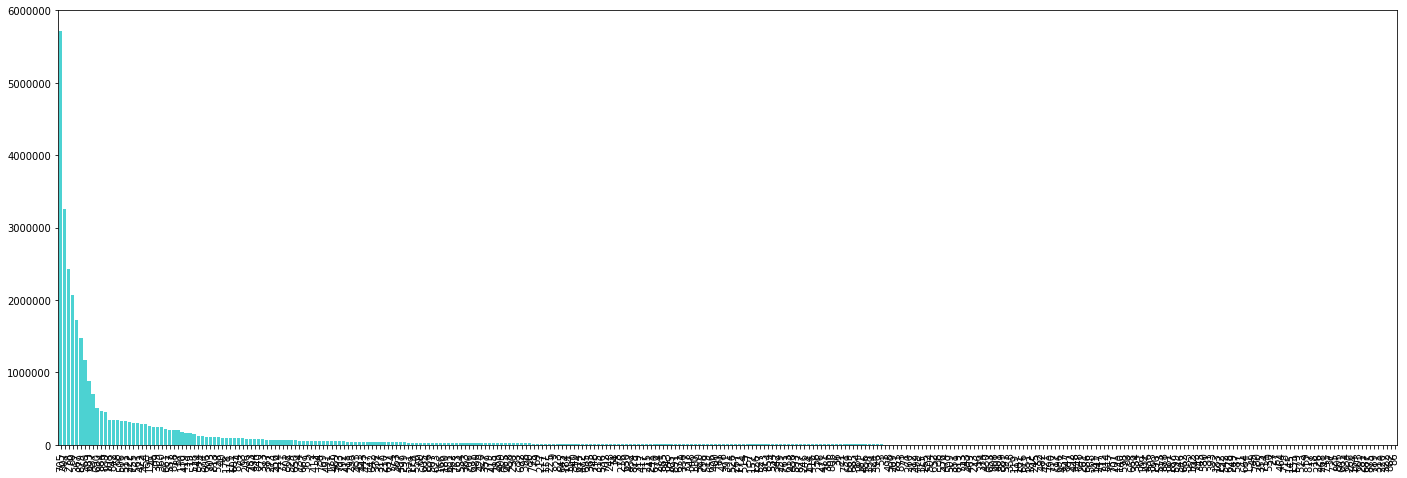

In [45]:
all_transactions.merchant_category_id.value_counts().plot(kind="bar", figsize=(24, 8), color="c", alpha=.7, width=.8)

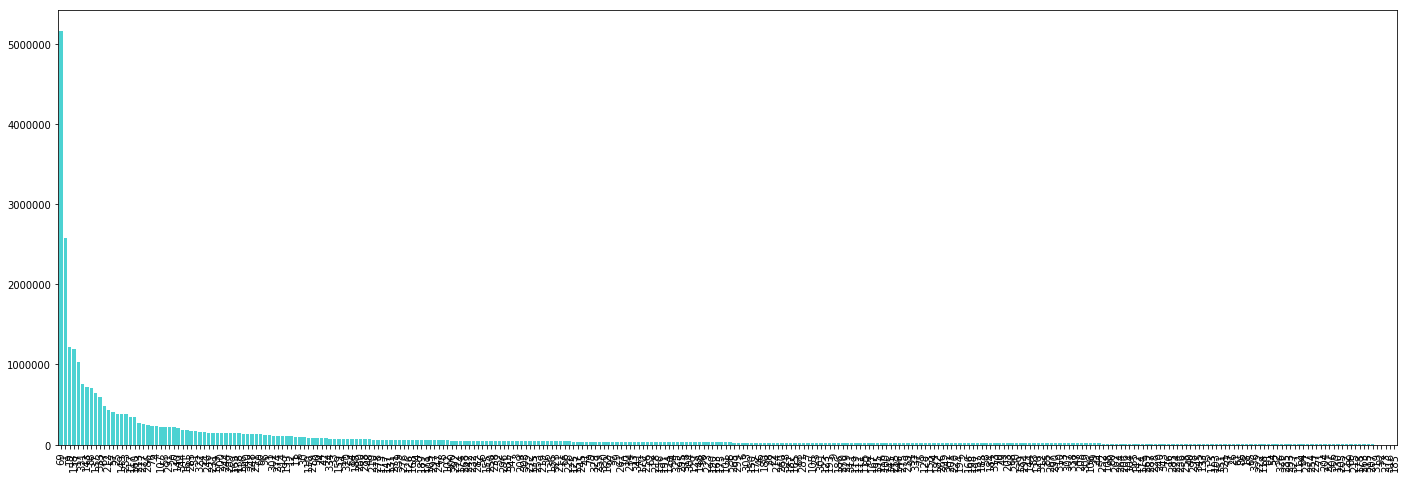

In [46]:
all_transactions.city_id.value_counts().plot(kind="bar", figsize=(24, 8), color="c", alpha=.7, width=.8)

In [49]:
all_transactions.city_id.value_counts().head(40)

 69     5164357
-1      2577973
 19     1222038
 158    1197975
 17     1037014
 331     755843
 143     722766
 88      705629
 137     648030
 333     592498
 87      478907
 212     438339
 57      405746
 25      385072
 149     381828
 233     381790
 117     342914
 160     340749
 213     269413
 277     263918
 286     247907
 76      230472
 4       229075
 107     225811
 53      223987
 291     222095
 20      220767
 140     208190
 344     187530
 161     182424
 283     175644
 51      175516
 322     163882
 21      158719
 246     150487
 231     150385
 179     149107
 200     145676
 244     144377
 289     141472
Name: city_id, dtype: int64

In [37]:
state_id_features = load_dataframe32("./data/features_downcast/transaction_frequent_state_id")

In [38]:
state_id_features.head().T

,0,1,2,3,4
state_id_-1,28,11,0,116,4
state_id_1,0,0,0,0,0
state_id_2,121,0,0,0,0
state_id_3,0,0,0,0,138
state_id_4,0,0,0,0,0
state_id_5,0,1,0,1,1
state_id_6,0,0,0,0,0
state_id_7,0,0,0,0,3
state_id_8,0,0,0,0,0
state_id_9,1,112,2,26,7


In [27]:
state_id_features.head().T

card_id,C_ID_00007093c1,C_ID_0001238066,C_ID_0001506ef0,C_ID_0001793786,C_ID_000183fdda
state_id_-1,28.0,11.0,0.0,116.0,4.0
state_id_1,0.0,0.0,0.0,0.0,0.0
state_id_2,121.0,0.0,0.0,0.0,0.0
state_id_3,0.0,0.0,0.0,0.0,138.0
state_id_4,0.0,0.0,0.0,0.0,0.0
state_id_5,0.0,1.0,0.0,1.0,1.0
state_id_6,0.0,0.0,0.0,0.0,0.0
state_id_7,0.0,0.0,0.0,0.0,3.0
state_id_8,0.0,0.0,0.0,0.0,0.0
state_id_9,1.0,112.0,2.0,26.0,7.0
